In [1]:
import numpy as np
import pandas as pd
from pyne import data, nucname
from pyne.material import Material
from matplotlib import pyplot as plt

%matplotlib inline

In /home/opotowsky/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/opotowsky/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/opotowsky/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/opotowsky/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/opotowsky/.local/lib/python3.6/site-packages/matplo

In [4]:
# reimplemented PyNE's Material gammas() method
def manual_gammas(nuclide):
    parent = nucname.id(nuclide)
    decay_c = data.decay_const(parent)
    energies = data.gamma_energy(parent)
    intensities = data.gamma_photon_intensity(parent)
    children = data.gamma_from_to_byparent(parent)
    decay_children = data.decay_data_children(parent)
    decay_branches = data.decay_photon_branch_ratio_byparent(parent)
    
    gammas_result = []
    for i, c in enumerate(children):
        for j, dc in enumerate(decay_children):
            # here is where we skip negative nuclides
            if c[0] > 0:
                if nucname.zzzaaa(c[0]) == nucname.zzzaaa(dc):
                    gammas_result.append((energies[i][0], decay_c*intensities[i][0]*decay_branches[j][0]))
    return gammas_result

## Fissile nuclides to look at

In [5]:
nuc_list = ['pu239', 'u235', 'pu240']

## Find Gamma Energies Using PyNE

1. Gamma energies are being retrieved for each nuclide
2. Then I make a material in PyNE of 1g of each nuclide 
3. Calculate a total intensity of each gamma energy returned

In [6]:
gamma_dflist = []
for nuc in nuc_list:
    gamlist = manual_gammas(nuc)
    gamma = pd.DataFrame(gamlist, columns = ['energy', 'rel_intensity'])
    mat = Material({nuc : 1}, 1)
    num_atoms = mat.mass * 6.02e23 / data.atomic_mass(nucname.id(nuc))
    gamma['total_intensity'] = num_atoms * gamma['rel_intensity']
    gamma['nucID'] = nuc
    gamma['half life (y)'] = data.half_life(nucname.id(nuc)) / 60 / 60 / 24 / 365.25
    gamma_dflist.append(gamma)
all_gammas = pd.concat(gamma_dflist).reset_index(drop=True)

## All Gamma Energies Plotted

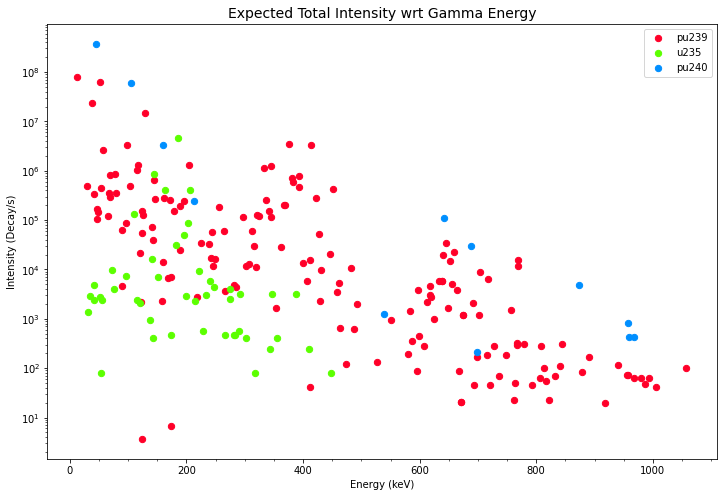

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
num_colors = len(nuc_list)
cm = plt.get_cmap('gist_rainbow')
for i, nuc in enumerate(nuc_list):
    ix = np.where(all_gammas['nucID'] == nuc)
    ax.scatter(all_gammas['energy'].iloc[ix], all_gammas['total_intensity'].iloc[ix], 
               color = cm(1.*i/num_colors), label = nuc, s = 40)
ax.minorticks_on()
plt.title('Expected Total Intensity wrt Gamma Energy', fontsize=14)
plt.yscale('log')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Intensity (Decay/s)')
ax.legend(loc='best')
plt.show()

## Expected Gamma Energy Lines, Min Intensity Set Arbitrarily @ 1e6

In [8]:
min_intensity = 1e6
exp_lines = all_gammas.loc[all_gammas['total_intensity'] > min_intensity].sort_values(['nucID', 'energy'])

In [9]:
exp_lines[['energy', 'total_intensity', 'nucID', 'half life (y)']].loc[exp_lines['nucID'] == 'pu239']

,energy,total_intensity,nucID,half life (y)
1,12.975,7.823165e+07,pu239,24110.0
3,38.661,2.395127e+07,pu239,24110.0
8,51.624,6.244767e+07,pu239,24110.0
10,56.828,2.642899e+06,pu239,24110.0
21,98.780,3.360978e+06,pu239,24110.0
23,115.380,1.059913e+06,pu239,24110.0
24,116.260,1.300802e+06,pu239,24110.0
31,129.296,1.447630e+07,pu239,24110.0
47,203.550,1.305390e+06,pu239,24110.0
68,332.845,1.133327e+06,pu239,24110.0


In [10]:
exp_lines[['energy', 'total_intensity', 'nucID', 'half life (y)']].loc[exp_lines['nucID'] == 'u235']

,energy,total_intensity,nucID,half life (y)
199,185.715,4.554819e+06,u235,704000000.0


In [11]:
exp_lines[['energy', 'total_intensity', 'nucID', 'half life (y)']].loc[exp_lines['nucID'] == 'pu240']

,energy,total_intensity,nucID,half life (y)
227,45.244,3.752726e+08,pu240,6561.0
228,104.234,5.994287e+07,pu240,6561.0
229,160.308,3.374935e+06,pu240,6561.0
